# Task 3: Generative models

## VAEs

In [ ]:
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output


from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive



### Dataset
We train our models on a subset of the `celebA` dataset.

(20000, 64, 64, 3)


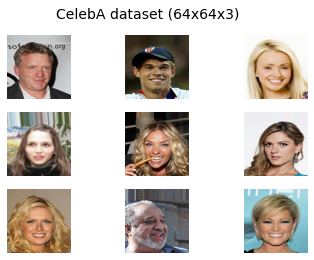

In [ ]:
def load_real_samples(scale=False):
    # We load 20,000 samples only to avoid memory issues, you can  change this value
    return np.load('/content/drive/MyDrive/faces_20000.npy')

# We will use this function to display the output of our models throughout this notebook
def grid_plot(images, epoch='', name='', n=3, save=False, scale=False):
    if scale:
        images = (images + 1) / 2.0
    for index in range(n * n):
        plt.subplot(n, n, 1 + index)
        plt.axis('off')
        plt.imshow(images[index])
    fig = plt.gcf()
    fig.suptitle(name + '  '+ str(epoch), fontsize=14)
    if save:
        filename = 'results/generated_plot_e%03d_f.png' % (epoch+1)
        plt.savefig(filename)
        plt.close()
    plt.show()


dataset = load_real_samples()
print(dataset.shape)
grid_plot(dataset[np.random.randint(0, 1000, 9)], name='CelebA dataset (64x64x3)', n=3)


def plot_loss(history, outname=None):
  pd.DataFrame(history.history).plot(
      figsize=(8, 5), xlim=[0, n_epochs], ylim=[0, 1], grid=True, xlabel="Epoch",
      style=["r--", "r--.", "b-", "b-*"])
  plt.legend(loc="lower left")  # extra code
  if outname != None:
    plt.savefig(outname, bbox_inches='tight', dpi=200)  # extra code
  plt.show()

#### Functions to build convolutional and deconvolutional neural netoworks.

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Reshape

def build_conv_net(in_shape, out_shape, n_downsampling_layers=4, filters=128, out_activation='sigmoid'):
    """
    Build a basic convolutional network
    """
    model = tf.keras.Sequential()
    default_args=dict(kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')

    model.add(Conv2D(input_shape=in_shape, **default_args, filters=filters))

    for _ in range(n_downsampling_layers):
        model.add(Conv2D(**default_args, filters=filters))

    model.add(Flatten())
    model.add(Dense(out_shape, activation=out_activation) )
    model.summary()
    return model


def build_deconv_net(latent_dim, n_upsampling_layers=4, filters=128, activation_out='sigmoid'):
    """
    Build a deconvolutional network for decoding/upscaling latent vectors

    When building the deconvolutional architecture, usually it is best to use the same layer sizes that 
    were used in the downsampling network and the Conv2DTranspose layers are used instead of Conv2D layers. 
    Using identical layers and hyperparameters ensures that the dimensionality of our output matches the
    shape of our input images. 
    """

    model = tf.keras.Sequential()
    model.add(Dense(4 * 4 * 64, input_dim=latent_dim)) 
    model.add(Reshape((4, 4, 64))) # This matches the output size of the downsampling architecture
    default_args=dict(kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')
    
    for i in range(n_upsampling_layers):
        model.add(Conv2DTranspose(**default_args, filters=filters))

    # This last convolutional layer converts back to 3 channel RGB image
    model.add(Conv2D(filters=3, kernel_size=(3,3), activation=activation_out, padding='same'))
    model.summary()
    return model

## Variational Autoencoders (VAEs)

In [ ]:
class Sampling(tf.keras.layers.Layer):
    """
    Custom layer for the variational autoencoder
    It takes two vectors as input - one for means and other for variances of the latent variables described by a multimodal gaussian
    Its output is a latent vector randomly sampled from this distribution
    """
    def call(self, inputs):
        z_mean, z_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_var) * epsilon

def build_vae(data_shape, latent_dim, filters=128):

    # Building the encoder - starts with a simple downsampling convolutional network  
    encoder = build_conv_net(data_shape, latent_dim*2, filters=filters)
    
    # Adding special sampling layer that uses the reparametrization trick 
    z_mean = Dense(latent_dim)(encoder.output)
    z_var = Dense(latent_dim)(encoder.output)
    z = Sampling()([z_mean, z_var])
    
    # Connecting the two encoder parts
    encoder = tf.keras.Model(inputs=encoder.input, outputs=z)

    # Defining the decoder which is a regular upsampling deconvolutional network
    decoder = build_deconv_net(latent_dim, activation_out='sigmoid', filters=filters)
    vae = tf.keras.Model(inputs=encoder.input, outputs=decoder(z))
    
    # Adding the special loss term
    kl_loss = -0.5 * tf.reduce_sum(z_var - tf.square(z_mean) - tf.exp(z_var) + 1)
    vae.add_loss(kl_loss/tf.cast(tf.keras.backend.prod(data_shape), tf.float32))

    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy')

    return encoder, decoder, vae


Define wrapping function to run a experiment for a given `latent_dimension`, `batch_size` and `num_epochs`

In [ ]:
# Training the VAE model
def run_vae(latent_dim, batch_size, num_epochs=20):
  encoder, decoder, vae = build_vae(dataset.shape[1:], latent_dim, filters=128)

  seed = np.random.seed(1998)
  latent_vector = np.random.randn(1, latent_dim)

  history = vae.fit(x=dataset, y=dataset, epochs=num_epochs, batch_size=batch_size)

  loss = np.array(history.history['loss'])
  image = decoder(latent_vector)[0,]

  labels = ['learning_curve','image']
  print('Saving...')
  for i,arr in enumerate([loss, image]):
      outname = '/content/drive/MyDrive/vae/{:}_ld{:}_bs{:}.npy'.format(labels[i], latent_dim, batch_size)
      np.save(outname, arr)
      print(outname)  
  return history

# Define grid of parameters
lds = [4, 16, 32, 64]
bss = [1, 10, 100, 500]

for ld in lds:
  for bs in bss:
      history = run_vae(ld, bs, num_epochs=5)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 128)         147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 2, 2, 128)         147584    
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 32)                1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/content/drive/MyDrive/vae/image_ld16_bs100.npy


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 conv2d_9 (Conv2D)           (None, 4, 4, 128)         147584    
                                                                 
 conv2d_10 (Conv2D)          (None, 2, 2, 128)         147584    
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 32)               

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/content/drive/MyDrive/vae/image_ld16_bs500.npy


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Results of VAEs experiment 
Read and plot results

In [ ]:
def get_output(lds, bss, label, curve=False):
    inds = []
    if curve:
      loss = []
    else:
      loss = np.zeros((len(lds), len(bss)))
    loss = []
    # loss = np.zeros((3, int(len(lds)*len(bss))))
    for j,bs in enumerate(bss):
          for i,ld in enumerate(lds):
            # print(ld,bs)
            file = '{:}_ld{:}_bs{:}.npy'.format(label, ld, bs)
            if curve:
              loss.append(np.load(file))
            else:
              # loss[i,j] = np.load(file)[-1]
              loss.append([ld, bs, np.load(file)[-1]])
            inds.append([ld, bs])
              # loss[i,j] = i*j
    return np.array(loss), np.array(inds)


lds = [8, 16, 32, 64, 128]
bss = [1, 10, 100, 500]

loss, inds = get_output(lds, bss, 'learning_curve', curve=False)
fig, ax = plt.subplots(1, figsize=(9,6))
# extent = [lds[0], lds[-1], bss[0], bss[-1]]
# obj = ax.imshow(loss, origin='lower', extent=extent, aspect='auto')
x,y,z = loss.T

cmap = plt.get_cmap('viridis', 10)
obj = ax.scatter(x,y, c=z, cmap=cmap, s=2e3, vmin=0.54, vmax=0.68)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_yticks([], minor=True)
ax.set_xticks([], minor=True)

ax.set(xlabel='Latent space dimension', ylabel='Batch size', yticks=bss, xticks=lds)
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

# ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label='Loss function')
fig.colorbar(obj, label='Loss')
plt.show()
# fig.savefig('latent_dim_batch_size.png', dpi=200, bbox_inches='tight')

#### Investigate the  relation between image features and latent space representation

In [ ]:
import matplotlib as mpl
def image_evolution(decoder, latent_dim, ind, n_samples, ax=None, seed=42):
    np.random.seed(seed)
    vector = np.random.randn(1,latent_dim)
    vector[0][ind] = 1. # set to one before multiplying by the range of values

    factor = np.linspace(-2., 2., n_samples) 
    for i in range(n_samples):
        new_vector = np.copy(vector)
        new_vector[0][ind] *= factor[i]
        image = decoder(new_vector)[0]
        ax[i].imshow(image)

# We identify the following relations:
# latent space dimension = feature
# 27 = background
# 31 = skin color

# plot the evolution of images over 10 steps
n_samples = 10

fig, ax = plt.subplots(2,n_samples,figsize=(12,4))
image_evolution(decoder, 32, 27, n_samples, ax=ax[0,:])
image_evolution(decoder, 32, 31, n_samples, ax=ax[1,:])
[axs.axis('off') for axs in ax.flatten()]

# add colorbar 
cmap = mpl.cm.viridis
bounds = np.linspace(-2, 2., n_samples+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.subplots_adjust(hspace=0.001, wspace=0.01)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, orientation='horizontal',
             label="Feature intensity", aspect=23., pad=0.05,
            ticks=np.linspace(-2,2, n_samples+1))

plt.show()
# fig.savefig('feature_intensity.png', dpi=200, bbox_inches='tight')

## GANs

We repeat a similar experiment for GANs.

In [ ]:
def load_real_samples(scale=False):
    # We load N samples to avoid memory issues
    # X = np.load('/content/drive/MyDrive/faces_20000.npy')
    
    X = np.load('/content/drive/MyDrive/faces_not-scaled_40000.npy')
    if scale:
      # X *= 255.
      X = (X-127.5) * 2
      X /= 255.
    return X

def grid_plot(images, epoch='', filename=None, n=3):
    fig, ax = plt.subplots(n,n,figsize=(n*n, n*n))
    for i,axi in enumerate(ax.flatten()):
      axi.imshow(images[i], aspect='auto')
      axi.axis('off')
    fig.subplots_adjust(hspace=0.01, wspace=0.01)
    fig.suptitle('GAN generated images epoch: '+ str(epoch), fontsize=14)
    plt.show()
    if filename != None:
      fig.savefig(filename, dpi=200, bbox_inches='tight', facecolor='white')


dataset = load_real_samples(scale=False)

Specific functions to build and train a GAN model

In [ ]:
def build_gan(data_shape, latent_dim, filters=128, lr=0.0002, beta_1=0.5):
    optimizer = tf.optimizers.Adam(learning_rate=lr, beta_1=beta_1)

    # Usually thew GAN generator has tanh activation function in the output layer
    generator = build_deconv_net(latent_dim, activation_out='tanh', filters=filters)
    
    # Build and compile the discriminator
    discriminator = build_conv_net(in_shape=data_shape, out_shape=1, filters=filters) # Single output for binary classification
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[tf.keras.metrics.Accuracy()])
    
    # End-to-end GAN model for training the generator
    discriminator.trainable = False
    true_fake_prediction = discriminator(generator.output)
    GAN = tf.keras.Model(inputs=generator.input, outputs=true_fake_prediction)
    GAN = tf.keras.models.Sequential([generator, discriminator])
    GAN.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return discriminator, generator, GAN


def run_generator(generator, n_samples=100):
  """
  Run the generator model and generate n samples of synthetic images using random latent vectors
  """
  latent_dim = generator.layers[0].input_shape[-1]
  generator_input = np.random.randn(n_samples, latent_dim)

  return generator.predict(generator_input)
    

def get_batch(generator, dataset, batch_size=64):
    """
    Gets a single batch of samples (X) and labels (y) for the training the discriminator.
    One half from the real dataset (labeled as 1s), the other created by the generator model (labeled as 0s).
    """
    batch_size //= 2 # Split evenly among fake and real samples

    fake_data = run_generator(generator, n_samples=batch_size)
    real_data = dataset[np.random.randint(0, dataset.shape[0], batch_size)]

    X = np.concatenate([fake_data, real_data], axis=0)
    y = np.concatenate([np.zeros([batch_size, 1]), np.ones([batch_size, 1])], axis=0)

    return X, y


def train_gan(generator, discriminator, gan, dataset, latent_dim, n_epochs=20, batch_size=64):
    folder = 'ld{:}_bs{:}_epochs{:}/'.format(latent_dim, batch_size, n_epochs)

    tf.random.set_seed(42)
    noise = np.random.randn(16, latent_dim)
    batches_per_epoch = int(dataset.shape[0] / batch_size / 2)
    d_loss, d_acc, g_loss = ([] for _ in range(3))
    for epoch in range(n_epochs):
        dl, da, gl = ([] for _ in range(3))
        for batch in tqdm(range(batches_per_epoch)):
            
            # 1) Train discriminator both on real and synthesized images
            X, y = get_batch(generator, dataset, batch_size=batch_size)
            dl1, da1 = discriminator.train_on_batch(X, y)
            dl.append(dl1)
            da.append(da1)

            # 2) Train generator (note that now the label of synthetic images is reversed to 1)
            X_gan = np.random.randn(batch_size, latent_dim)
            y_gan = np.ones([batch_size, 1])
            gl.append(gan.train_on_batch(X_gan, y_gan))
        
        d_loss.append(dl)
        d_acc.append(da)
        g_loss.append(gl)

        images = generator.predict(noise)
        # grid_plot(images, epoch, filename=path+folder+'gan_image_epoch-{:}.png'.format(epoch), n=3, scale=True)
        grid_plot(images, epoch, filename=path+folder+'gan_image_epoch-{:}.png'.format(1+epoch), n=3)
    lal = [d_loss, d_acc, g_loss]
    return generator, lal


In [ ]:
# Run experiment and save results

n_epochs = 20 # original value
ld = [64, 128, 256, 512]
bs = [32, 64, 128, 256]

nfaces = dataset.shape[0] # number of samples

for latent_dim in ld:
  for batch_size in bs:
    discriminator, generator, gan = build_gan(dataset.shape[1:], latent_dim, filters=128)

    generator, lal = train_gan(generator, discriminator, gan, dataset, latent_dim, n_epochs, batch_size)
    outname = '/content/drive/MyDrive/gans/gan_history_{:}_latdim{:}_batchsize{:}_epochs{:}'.format(nfaces, latent_dim, batch_size, n_epochs)
    np.save(outname, np.array(lal))
    generator.save('/content/drive/MyDrive/gans/generator_{:}_latdim{:}_batchsize{:}_epochs{:}'.format(nfaces, latent_dim, batch_size, n_epochs))


Results of GANs experiment

In [ ]:
import os, glob
from matplotlib.ticker import FormatStrFormatter
plt.rcParams.update({'font.size':16})

def read_files():
    files = glob.glob('*.npy')
    # print(files)
    
    # ax = ax or plt.gca()
    fig, ax = plt.subplots(1, figsize=(9,6))

    latdim = []
    bs = []
    loss = []
    dis_loss = []
    for f in files:
        split = f.split('_')
        latdim.append(int(split[2].split('latdim')[-1]))
        bs.append(int(split[3].split('batchsize')[-1]))
        data = np.load(f)[0].flatten()
        
        dis_loss.append(data)
        ind = int(data.size*0.90)
        loss.append(data[ind:].mean())

    x,y,z = latdim, bs, loss

    cmap = plt.get_cmap('viridis', 9)
    obj = ax.scatter(x,y, c=z, cmap=cmap, s=2e3, vmin=0.30)

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_yticks([], minor=True)
    ax.set_xticks([], minor=True)
    ax.set(xlabel='Latent space dimension', ylabel='Batch size', 
           yticks=np.unique(bs), xticks=np.unique(latdim))
    
    
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

    fig.colorbar(obj, label='Discriminant Loss')
    plt.show()
    # fig.savefig('gan_latent_dim_batch_size.png', dpi=200, bbox_inches='tight')
    
    return latdim, bs, dis_loss

# Scatter plot with LOSS values for each (latent_dim, batch_size) pair
latdim, bs, loss = read_files()

## Second plot: Learning curve
fig, ax = plt.subplots(1, figsize=(7,3.5))
ld, bs = 256, 32
best = np.load('gan_history_latdim{:}_batchsize{:}_epochs20.npy'.format(ld, bs))
y = best[0].flatten()

ind = int(y.size*0.90)
bloss = y[ind:].mean()
bloss_std = y[ind:].std()

print('{:.2f} +- {:.2f}'.format(y.mean(), y.std()))


axins = ax.inset_axes([0.5, 0.5, 0.47, 0.47])
# sub region of the original image
x1, x2, y1, y2 = ind, y.size, 0, 1.
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_yticklabels([])
axins.set_xticklabels([])

ax.indicate_inset_zoom(axins, edgecolor="black")


for ax_i in [ax, axins]:
    ax_i.axvspan(0, ind, alpha=0.15, fc='red')
    ax_i.axvspan(ind, y.size, alpha=0.15, fc='g')

    ax_i.plot(y, c='coral', alpha=0.95, lw=0.8)
    ax_i.plot(np.ones_like(y)*bloss,ls='--', c='g', 
              label='Loss = {:.2f} $\pm$ {:.2f}'.format(bloss, bloss_std))
ax.set(xlim=(0, y.size), ylim=(0, 3.), ylabel='Discriminant loss', xlabel='Iteration')


ax.legend(loc='upper left', fontsize=14)
plt.show()
# fig.savefig('gan_history_best.png', dpi=200, bbox_inches='tight')

Latent-space representation of image features

In [ ]:
# We identify the following relations:
# latent space dimension = feature
# 222 = moustache
# 25 = background

# plot the evolution of the images over 10 steps
n_samples = 10

fig, ax = plt.subplots(2,n_samples,figsize=(12,4))
image_evolution(generator, ld, 222, n_samples, ax=ax[0,:], seed=440)
image_evolution(generator, ld, 25, n_samples, ax=ax[1,:], seed=440)
[axs.axis('off') for axs in ax.flatten()]

# add colorbar 
cmap = mpl.cm.viridis
bounds = np.linspace(-4, 4., n_samples+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.subplots_adjust(hspace=0.001, wspace=0.01)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax=ax, orientation='horizontal',
             label="Feature intensity", aspect=23., pad=0.05,
            ticks=bounds)

plt.show()
# fig.savefig('feature_intensity.png', dpi=200, bbox_inches='tight')